# Study of Displaced Track Reconstruction Performance in DarkQuest

Notebook used to document the study of the displaced track reconstruction performance

very preliminary. Most work still ongoing

In [1]:
import uproot3
import numpy as np
import numba
import awkward1 as ak
import awkward as ak0

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.CMS)
import os,sys
import pandas as pd
from scipy.stats import halfnorm
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from scipy.stats import binned_statistic

In [2]:
def getData(fname="", procName="Truth"):
    dq_dict = uproot3.open(fname)["Truth"].arrays()
    dq_dict_ak1 = {name.decode(): ak.from_awkward0(array) for name, array in dq_dict.items()}
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "GenVertex": ak.zip({
                                            "vx": dq_dict_ak1["gvx"],
                                            "vy": dq_dict_ak1["gvy"],
                                            "vz": dq_dict_ak1["gvz"],

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict_ak1["gpx_st1"],
                                            "py": dq_dict_ak1["gpy_st1"],
                                            "pz": dq_dict_ak1["gpz_st1"],
                                            "x": dq_dict_ak1["gx_st1"],
                                            "y": dq_dict_ak1["gy_st1"],
                                            "z": dq_dict_ak1["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        })
                       }, depth_limit=1)
    return dq_events

Load data into awkward array. 

The data are the outputs from the `Fun4Sim_Ap2Muons.C` macro

In [3]:
filename = "/seaquest/users/yfeng/DarkQuest/DarkQuest/e1039-analysis/SimHits/macro/output.root"
dq_events = getData(filename)

Plot the Aprime decaying to dimuon vertex position

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


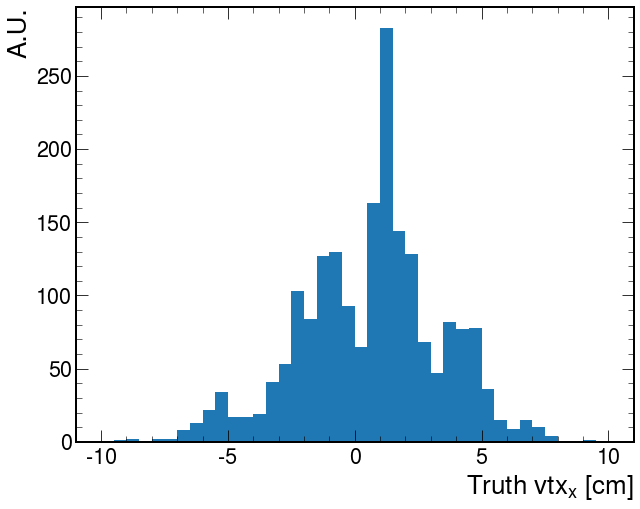

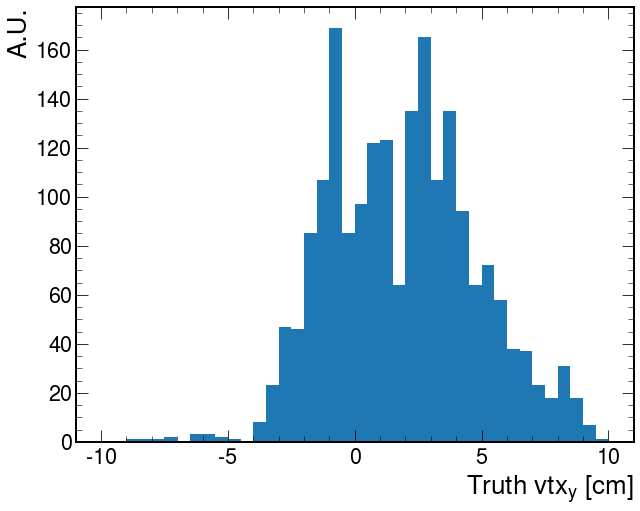

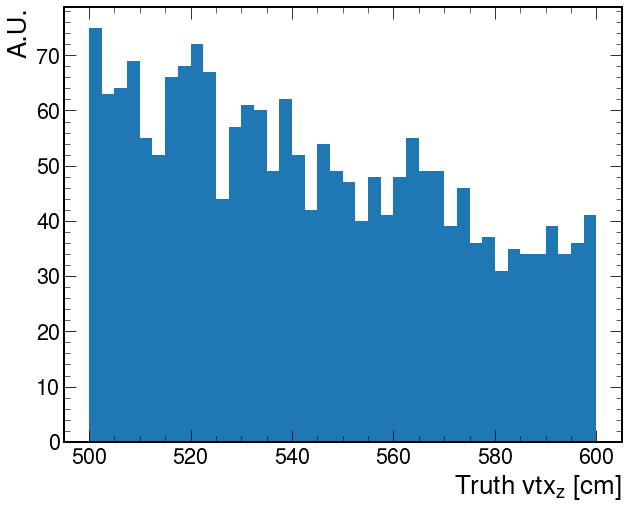

In [4]:
fig = plt.figure(figsize=(10,8))
plt.hist(dq_events['GenVertex'].vx[:,0], bins=40, range=(-10,10), density=False)
#plt.xlim(0,40)
plt.xlabel("Truth $vtx_x$ [cm]")
plt.ylabel('A.U.')
plt.savefig("plots/truth_vertex_vx.png")

fig = plt.figure(figsize=(10,8))
plt.hist(dq_events['GenVertex'].vy[:,0], bins=40, range=(-10,10), density=False)
#plt.xlim(0,40)
plt.xlabel("Truth $vtx_y$ [cm]")
plt.ylabel('A.U.')
plt.savefig("plots/truth_vertex_vy.png")

fig = plt.figure(figsize=(10,8))
plt.hist(dq_events['GenVertex'].vz[:,0], bins=40, range=(500,600), density=False)
#plt.xlim(0,40)
plt.xlabel("Truth $vtx_z$ [cm]")
plt.ylabel('A.U.')
plt.savefig("plots/truth_vertex_vz.png")

Plot the dimuon momentum distribution at Station1

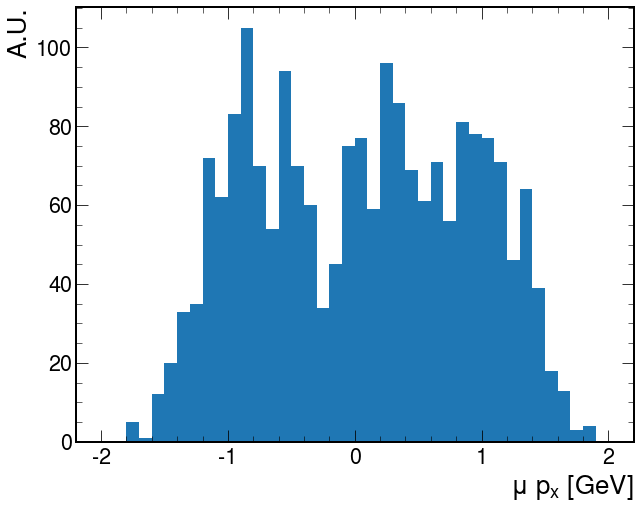

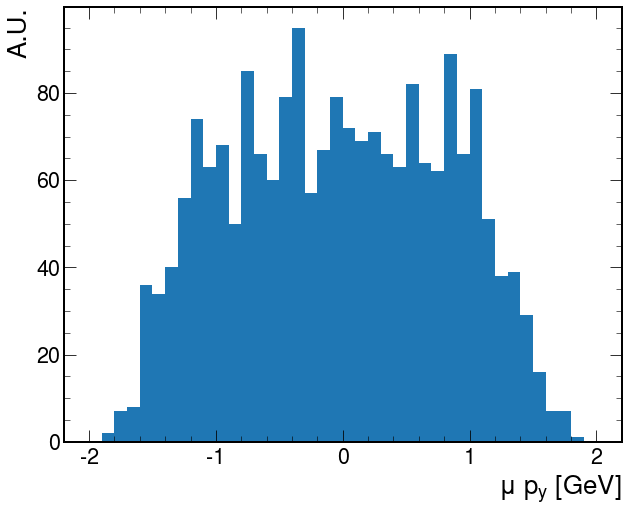

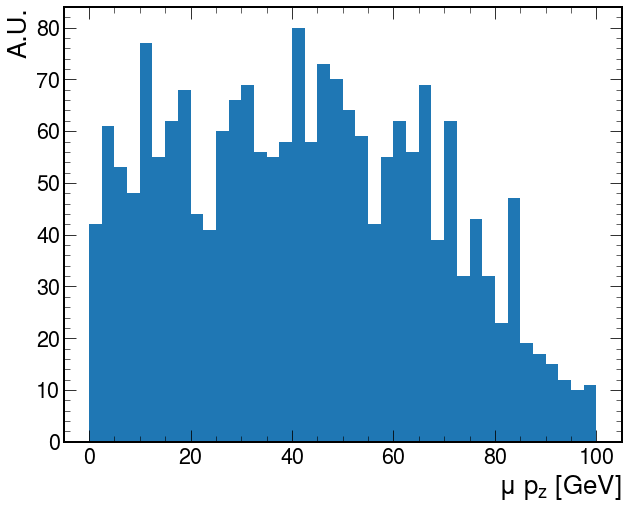

In [5]:
fig = plt.figure(figsize=(10,8))
plt.hist(dq_events['GenP_St1'].px[:,0], bins=40, range=(-2,2), density=False)
#plt.xlim(0,40)
plt.xlabel("$\mu$ $p_x$ [GeV]")
plt.ylabel('A.U.')
plt.savefig("plots/Muon_Px.png")

fig = plt.figure(figsize=(10,8))
plt.hist(dq_events['GenP_St1'].py[:,0], bins=40, range=(-2,2), density=False)
#plt.xlim(0,40)
plt.xlabel("$\mu$ $p_y$ [GeV]")
plt.ylabel('A.U.')
plt.savefig("plots/Muon_Py.png")

fig = plt.figure(figsize=(10,8))
plt.hist(dq_events['GenP_St1'].pz[:,0], bins=40, range=(0,100), density=False)
#plt.xlim(0,40)
plt.xlabel("$\mu$ $p_z$ [GeV]")
plt.ylabel('A.U.')
plt.savefig("plots/Muon_Pz.png")

In [6]:
GenMuons = dq_events['GenP_St1']
RecoMuons = dq_events["Track_St1"]
GenVertices = dq_events['GenVertex']
nTracks = dq_events['nTrack']

In [7]:
# only look at the events with two tracks reconstructed for now
# because it is easier to match the pz
events_selected = (nTracks.n_tracks > 1)
RecoMuons_selected = RecoMuons[events_selected]
GenMuons_selected = GenMuons[events_selected]
GenVertices_selected = GenVertices[events_selected]

# take the max so that no need to do matching
# not always correct, but should work at leading order
index_reco_pzmax = ak.argmax(RecoMuons_selected.pz, axis=1, keepdims=True)
index_gen_pzmax = ak.argmax(GenMuons_selected.pz, axis=1, keepdims=True)

Compare the **truth position change** from vtx to st1 (i.e., (x_st1-x_vtx, y_st1-y_vtx, z_st1-z_vtx)) and the **truth momentum vector** (px, py, pz) and see if they align well
(the momentum vector at st1 and vtx are very close)

In [11]:
gen_x_over_px = ak.flatten(GenMuons_selected.x - GenVertices_selected.vx)/ak.flatten(GenMuons_selected.px)
gen_y_over_py = ak.flatten(GenMuons_selected.y - GenVertices_selected.vy)/ak.flatten(GenMuons_selected.py)
gen_z_over_pz = ak.flatten(GenMuons_selected.z - GenVertices_selected.vz)/ak.flatten(GenMuons_selected.pz)

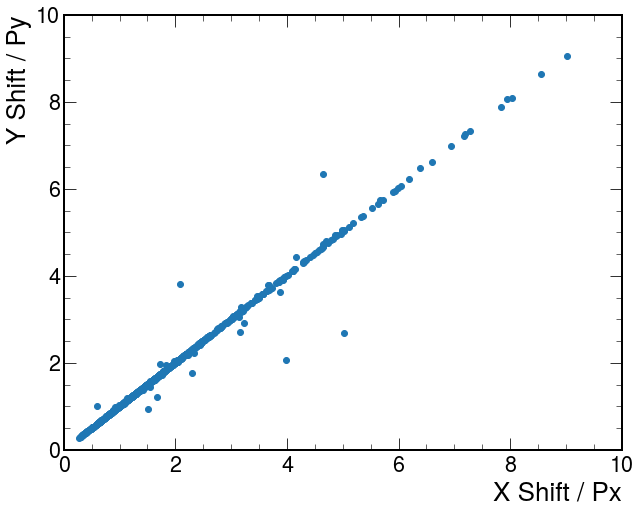

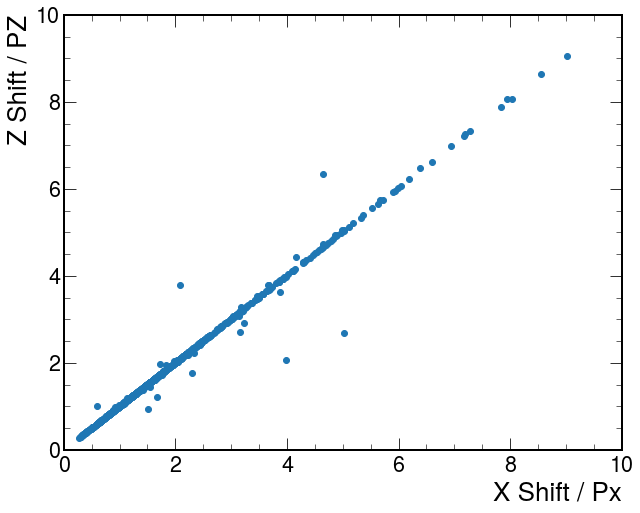

In [12]:
fig = plt.figure(figsize=(10,8))
plt.scatter(gen_x_over_px, gen_y_over_py)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel("X Shift / Px")
plt.ylabel('Y Shift / Py')
plt.savefig("plots/move_xy.png")

fig = plt.figure(figsize=(10,8))
plt.scatter(gen_x_over_px, gen_z_over_pz)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel("X Shift / Px")
plt.ylabel('Z Shift / PZ')
plt.savefig("plots/move_xz.png")

Compare the **reco position change** from truth vtx to reco st1 (i.e., (x_reco_st1-x_vtx, y_reco_st1-y_vtx, z_reco_st1-z_vtx)) and the **reco momentum vector** (px, py, pz) and see if they align well
(the momentum vector at st1 and vtx are very close)

In [14]:
reco_x_over_px = ak.flatten(RecoMuons_selected[index_reco_pzmax].x - GenVertices_selected[index_gen_pzmax].vx)/ak.flatten(RecoMuons_selected[index_reco_pzmax].px)
reco_y_over_py = ak.flatten(RecoMuons_selected[index_reco_pzmax].y - GenVertices_selected[index_gen_pzmax].vy)/ak.flatten(RecoMuons_selected[index_reco_pzmax].py)
reco_z_over_pz = ak.flatten(RecoMuons_selected[index_reco_pzmax].z - GenVertices_selected[index_gen_pzmax].vz)/ak.flatten(RecoMuons_selected[index_reco_pzmax].pz)

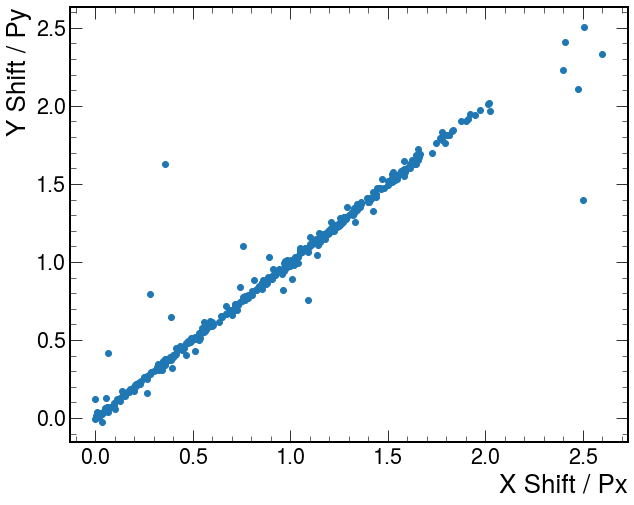

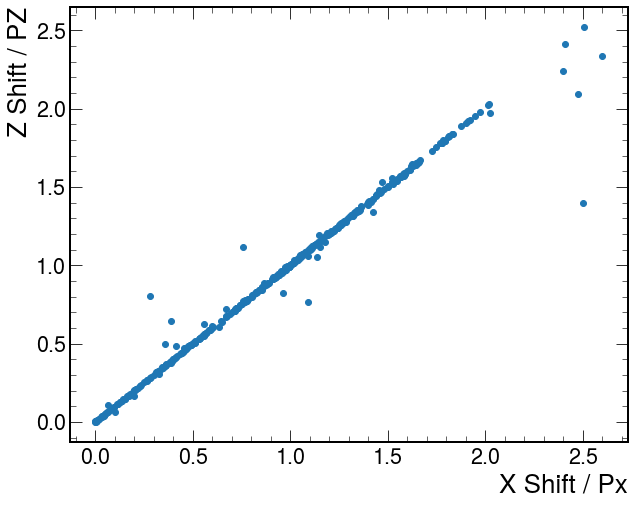

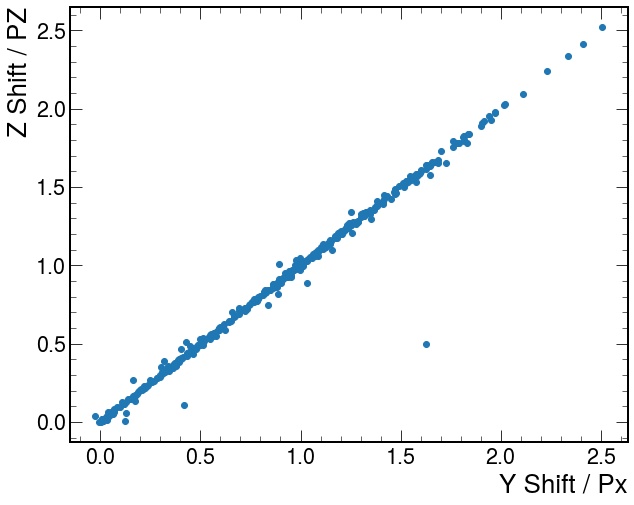

In [15]:
fig = plt.figure(figsize=(10,8))
plt.scatter(reco_x_over_px, reco_y_over_py)
#plt.xlim(0,10)
#plt.ylim(0,10)
plt.xlabel("X Shift / Px")
plt.ylabel('Y Shift / Py')
plt.savefig("plots/move_xy_reco.png")

fig = plt.figure(figsize=(10,8))
plt.scatter(reco_x_over_px, reco_z_over_pz)
#plt.xlim(0,10)
#plt.ylim(0,10)
plt.xlabel("X Shift / Px")
plt.ylabel('Z Shift / PZ')
plt.savefig("plots/move_xz_reco.png")

fig = plt.figure(figsize=(10,8))
plt.scatter(reco_y_over_py, reco_z_over_pz)
#plt.xlim(0,10)
#plt.ylim(0,10)
plt.xlabel("Y Shift / Px")
plt.ylabel('Z Shift / PZ')
plt.savefig("plots/move_yz_reco.png")

In [16]:
pz_diff = ak.flatten(RecoMuons_selected[index_reco_pzmax].pz - GenMuons_selected[index_gen_pzmax].pz)
py_diff = ak.flatten(RecoMuons_selected[index_reco_pzmax].py - GenMuons_selected[index_gen_pzmax].py)
px_diff = ak.flatten(RecoMuons_selected[index_reco_pzmax].px - GenMuons_selected[index_gen_pzmax].px)

Plot the difference between the reco track and gen muon momentum 

(Only check the leading muon in each event for now)

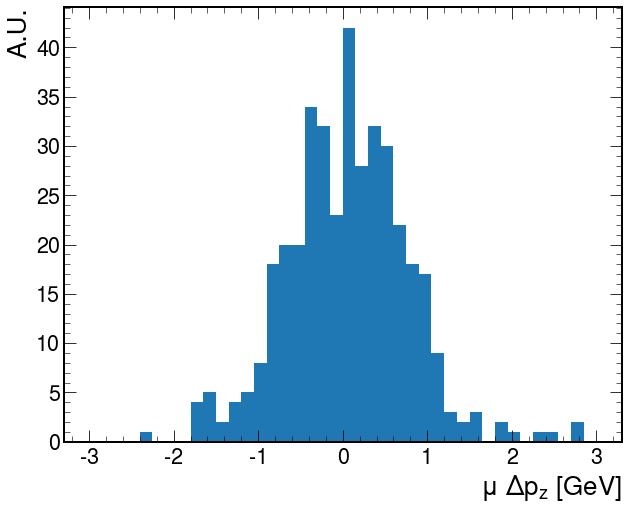

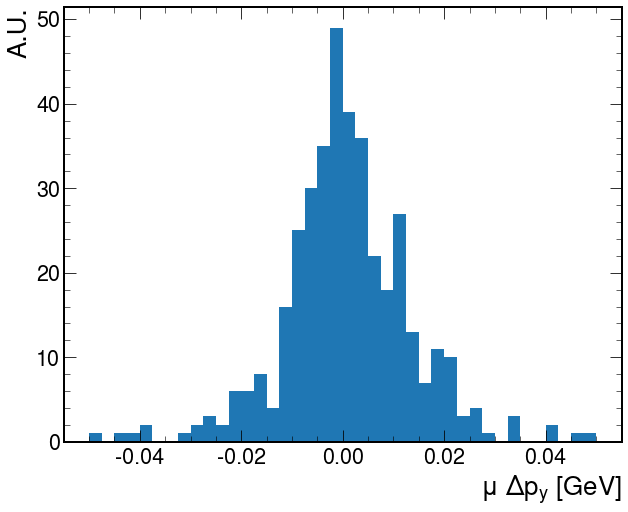

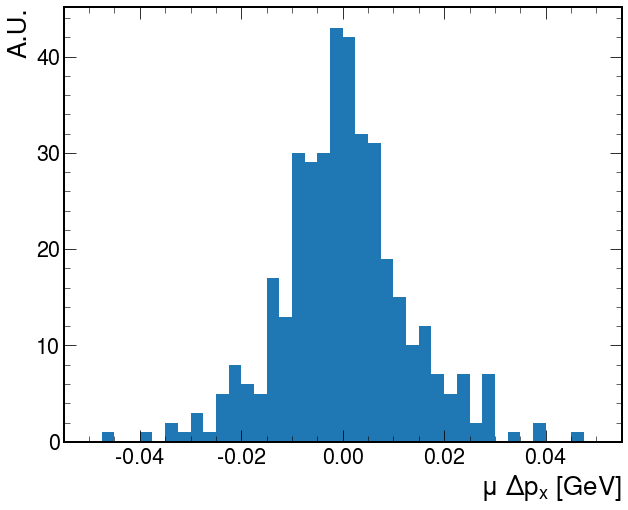

In [17]:
fig = plt.figure(figsize=(10,8))
#n, bins, patches = plt.hist(RecoMuons_selected_pz_max-GenMuons_selected_pz_max, 60, normed=1, facecolor='green', alpha=0.75)
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=2)
plt.hist(pz_diff, bins=40, range=(-3,3), density=False)
#plt.xlim(0,40)
plt.xlabel("$\mu$ $\Delta p_z$ [GeV]")
plt.ylabel('A.U.')
plt.savefig("plots/Muon_DeltaPz.png")

fig = plt.figure(figsize=(10,8))
#n, bins, patches = plt.hist(RecoMuons_selected_pz_max-GenMuons_selected_pz_max, 60, normed=1, facecolor='green', alpha=0.75)
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=2)
plt.hist(py_diff, bins=40, range=(-0.05,0.05), density=False)
#plt.xlim(0,40)
plt.xlabel("$\mu$ $\Delta p_y$ [GeV]")
plt.ylabel('A.U.')
plt.savefig("plots/Muon_DeltaPy.png")

fig = plt.figure(figsize=(10,8))
#n, bins, patches = plt.hist(RecoMuons_selected_pz_max-GenMuons_selected_pz_max, 60, normed=1, facecolor='green', alpha=0.75)
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=2)
plt.hist(px_diff, bins=40, range=(-0.05,0.05), density=False)
#plt.xlim(0,40)
plt.xlabel("$\mu$ $\Delta p_x$ [GeV]")
plt.ylabel('A.U.')
plt.savefig("plots/Muon_DeltaPx.png")

Check the reconstruction efficiency in each bin

(To be 100% correct, the matching needs to be done first. Here do the fast efficiency estimation by taking the ratio of the number of reconstructed tracked vs number of gen muons in each pz bin.)

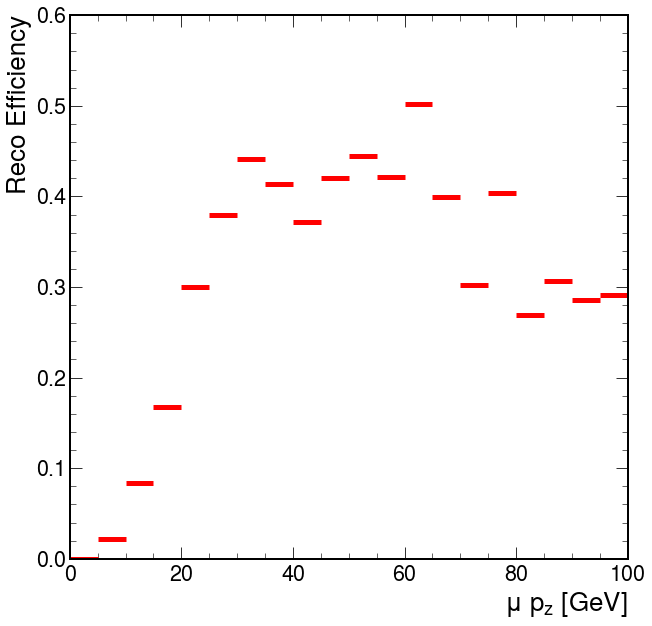

In [18]:
nreco, bin_edges = np.histogram(ak.to_numpy(ak.flatten(RecoMuons.pz)), bins=20, range=(0,100))
ngen, bin_edges  = np.histogram(ak.to_numpy(ak.flatten(GenMuons.pz)), bins=20, range=(0,100))

plt.figure()
plt.hlines(nreco/ngen, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
plt.xlim(0,100)
plt.ylim(0,0.6)
plt.xlabel('$\mu$ $p_z$ [GeV]')
#plt.ylabel('<$E_{Cluster}$>/<$E_{Gen}$>')
plt.ylabel('Reco Efficiency')
plt.savefig("plots/REco Efficiency.png")